## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


import numpy as np
from google.colab import autoviz
df_1117935977783486013 = autoviz.get_registered_df('df_1117935977783486013')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1117935977783486013, *['survived'], **{})
chart

import numpy as np
from google.colab import autoviz
df_9129518359625189005 = autoviz.get_registered_df('df_9129518359625189005')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_9129518359625189005, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz
df_589483121665266566 = autoviz.get_registered_df('df_589483121665266566')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_589483121665266566, *['sibsp'], **{})
chart

import numpy as np
from google.colab import autoviz
df_992993969551110394 = autoviz.get_registered_df('df_992993969551110394')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_992993969551110394, *['parch'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8758190444090335669 = autoviz.get_registered_df('df_8758190444090335669')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8758190444090335669, *['survived'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1462858185948497850 = autoviz.get_registered_df('df_1462858185948497850')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1462858185948497850, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2608861316189610741 = autoviz.get_registered_df('df_2608861316189610741')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2608861316189610741, *['sibsp'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3830317251224919935 = autoviz.get_registered_df('df_3830317251224919935')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3830317251224919935, *['parch'], **{})
chart

import numpy as np
from google.colab import autoviz
df_9118836560362050559 = autoviz.get_registered_df('df_9118836560362050559')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_9118836560362050559, *['sex'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6391889049085758372 = autoviz.get_registered_df('df_6391889049085758372')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_6391889049085758372, *['cabin'], **{})
chart

import numpy as np
from google.colab import autoviz
df_691520954307136267 = autoviz.get_registered_df('df_691520954307136267')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_691520954307136267, *['title'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6848983930585187078 = autoviz.get_registered_df('df_6848983930585187078')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_6848983930585187078, *[[['survived', 'age'], ['age', 'sibsp'], ['sibsp', 'parch'], ['parch', 'fare']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_1863098517249399197 = autoviz.get_registered_df('df_1863098517249399197')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_1863098517249399197, *['sex', 'cabin'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8271789806714898141 = autoviz.get_registered_df('df_8271789806714898141')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_8271789806714898141, *['cabin', 'title'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2454276791228598538 = autoviz.get_registered_df('df_2454276791228598538')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_2454276791228598538, *['survived', 'sex'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_6266349048168594878 = autoviz.get_registered_df('df_6266349048168594878')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_6266349048168594878, *['survived', 'cabin'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_7423127074946251375 = autoviz.get_registered_df('df_7423127074946251375')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_7423127074946251375, *['survived', 'title'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_8160083207505275328 = autoviz.get_registered_df('df_8160083207505275328')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_8160083207505275328, *['age', 'sex'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_6695571315465931242 = autoviz.get_registered_df('df_6695571315465931242')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_6695571315465931242, *['sibsp', 'survived', 'sex'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4112550596514375193 = autoviz.get_registered_df('df_4112550596514375193')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4112550596514375193, *['sibsp', 'survived', 'cabin'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8900390926230363669 = autoviz.get_registered_df('df_8900390926230363669')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8900390926230363669, *['sibsp', 'survived', 'title'], **{})
chart

import numpy as np
from google.colab import autoviz
df_275126928222138485 = autoviz.get_registered_df('df_275126928222138485')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_275126928222138485, *['sibsp', 'age', 'sex'], **{})
chart

In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
[var for var in data.columns if data[var].dtype == 'O']

['sex', 'cabin', 'embarked', 'title']

In [11]:
[var for var in data.columns if data[var].dtype != 'O' and var != 'survived']

['pclass', 'age', 'sibsp', 'parch', 'fare']

In [12]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [13]:
# first in numerical variables
[var for var in vars_num if data[var].isnull().sum() > 0]

['age', 'fare']

In [14]:
# now in categorical variables
[var for var in vars_cat if data[var].isnull().sum() > 0]


['cabin', 'embarked']

### Determine cardinality of categorical variables

In [15]:
for var in vars_cat:
  print(var, data[var].unique())
  print(len(data[var].unique()))

sex ['female' 'male']
2
cabin ['B5' 'C22' 'E12' 'D7' 'A36' 'C101' nan 'C62' 'B35' 'A23' 'B58' 'D15' 'C6'
 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T' 'A31' 'C7' 'C103' 'D22' 'E33'
 'A21' 'B10' 'B4' 'E40' 'B38' 'E24' 'B51' 'B96' 'C46' 'E31' 'E8' 'B61'
 'B77' 'A9' 'C89' 'A14' 'E58' 'E49' 'E52' 'E45' 'B22' 'B26' 'C85' 'E17'
 'B71' 'B20' 'A34' 'C86' 'A16' 'A20' 'A18' 'C54' 'C45' 'D20' 'A29' 'C95'
 'E25' 'C111' 'C23' 'E36' 'D34' 'D40' 'B39' 'B41' 'B102' 'C123' 'E63'
 'C130' 'B86' 'C92' 'A5' 'C51' 'B42' 'C91' 'C125' 'D10' 'B82' 'E50' 'D33'
 'C83' 'B94' 'D49' 'D45' 'B69' 'B11' 'E46' 'C39' 'B18' 'D11' 'C93' 'B28'
 'C49' 'B52' 'E60' 'C132' 'B37' 'D21' 'D19' 'C124' 'D17' 'B101' 'D28' 'D6'
 'D9' 'B80' 'C106' 'B79' 'C47' 'D30' 'C90' 'E38' 'C78' 'C30' 'C118' 'D36'
 'D48' 'D47' 'C105' 'B36' 'B30' 'D43' 'B24' 'C2' 'C65' 'B73' 'C104' 'C110'
 'C50' 'B3' 'A24' 'A32' 'A11' 'A10' 'B57' 'C28' 'E44' 'A26' 'A6' 'A7'
 'C31' 'A19' 'B45' 'E34' 'B78' 'B50' 'C87' 'C116' 'C55' 'D50' 'E68' 'E67'
 'C126' 'C68' 'C70' 'C

### Determine the distribution of numerical variables

pclass


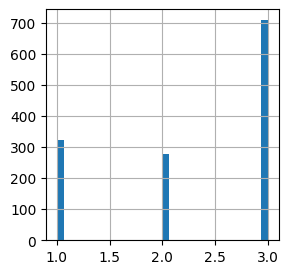

age


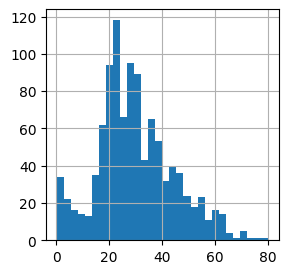

sibsp


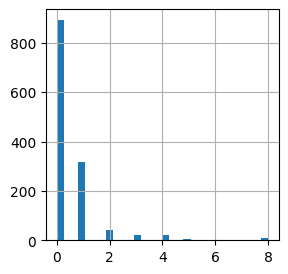

parch


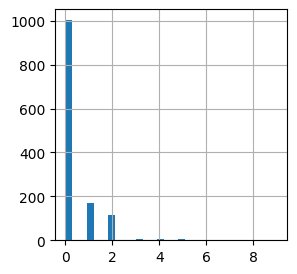

fare


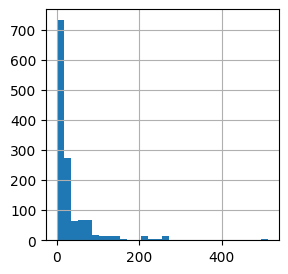

In [16]:
for var in vars_num:
  print(var)
  data[var].hist(bins=30, figsize=(3,3))
  plt.show()

In [17]:
(data['fare'] < 20).sum()

752

In [18]:
len(data)

1309

In [20]:
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [22]:
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [26]:
temp_list = X_train['cabin'].unique()
temp_list

array([nan, 'E40', 'F', 'A19', 'C32', 'D', 'B79', 'C62', 'E8', 'D28',
       'C45', 'C46', 'B22', 'B57', 'C23', 'E44', 'B45', 'B39', 'B58',
       'F2', 'C47', 'B101', 'D21', 'A7', 'E52', 'F38', 'E36', 'C68',
       'E24', 'C22', 'D38', 'B50', 'A24', 'C111', 'C6', 'C87', 'C93',
       'D36', 'C125', 'B35', 'T', 'B73', 'A26', 'A18', 'B96', 'G6', 'C78',
       'C101', 'D9', 'D33', 'C128', 'E50', 'B26', 'B69', 'E121', 'C123',
       'B94', 'A34', 'C39', 'D43', 'E31', 'B5', 'D17', 'F33', 'D7', 'A21',
       'D34', 'A29', 'D35', 'A11', 'B51', 'D46', 'E60', 'C30', 'D26',
       'E68', 'A9', 'B71', 'D37', 'C55', 'C89', 'C124', 'C126', 'E49',
       'E46', 'D19', 'C82', 'B52', 'C92', 'E45', 'C65', 'E25', 'B3',
       'D40', 'C91', 'B102', 'B61', 'A20', 'B36', 'C7', 'B77', 'D20',
       'C148', 'C105', 'E38', 'B86', 'C132', 'C86', 'A14', 'C54', 'A5',
       'B49', 'B28', 'B24', 'C2', 'F4', 'A6', 'C83', 'B42', 'A36', 'C52',
       'D56', 'C116', 'B19', 'E77', 'E101', 'B18', 'C95', 'D15', 'E33',


In [46]:
def get_cabin_letter(old_cabin):
    line = old_cabin
    if type(line) is str:
      return line[0]
    else:
      return line

X_train['cabin'] = X_train['cabin'].apply(get_cabin_letter)
X_test['cabin'] = X_test['cabin'].apply(get_cabin_letter)

In [49]:
X_test['cabin'].unique()

array([nan, 'G', 'E', 'C', 'B', 'A', 'F', 'D'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [53]:
vars_num

['pclass', 'age', 'sibsp', 'parch', 'fare']

In [55]:
num_with_missing = [var for var in vars_num if data[var].isnull().sum() > 0]
num_with_missing

['age', 'fare']

In [56]:
data[num_with_missing].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [59]:
for var in num_with_missing:
  X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
  X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

In [63]:
X_train['fare'].median()

14.4542

In [65]:
for var in num_with_missing:
  median_val = X_train[var].median()
  X_train[var] = X_train[var].fillna(median_val)
  X_test[var] = X_test[var].fillna(median_val)

In [66]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_NA,fare_NA
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,NaN,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,NaN,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [68]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [69]:
cat_with_missing = [var for var in vars_cat if data[var].isnull().sum() > 0]
cat_with_missing

['cabin', 'embarked']

In [70]:
for var in cat_with_missing:
  X_train[var] = X_train[var].fillna('Missing')
  X_test[var] = X_test[var].fillna('Missing')

In [71]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_NA,fare_NA
1118,3,male,25.0000,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,Missing,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,Missing,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,Missing,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,Missing,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,Missing,S,Miss,0,0


In [72]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [73]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [92]:

temp = X_train.groupby('cabin')['cabin'].count() / len(X_train)
temp[temp > 0.05]

cabin
C          0.074499
Missing    0.766953
Name: cabin, dtype: float64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

### Scale the variables

- Use the standard scaler from Scikit-learn

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**